# Table of Contents
1. [Introduction](#Introduction)

2. [A prototype example](#Example)

3. [A simple economic dispatch model with LP](#A_simple_economic_dispatch_model_with_LP)

    3.1. [Sensitivity analysis usig Duality](#sensitivity_analysis_LP)
    
    3.2. [Parametric Sensitivity Analysis](#parametric_sensitivity_analysis)

4. [A first MIP model](#A_first_MIP_formulation)

5. [An MIP model with startup costs](#An_MIP_model_with_startup_costs)

6. [An MIP model with up- and down-time constraints](#An_MIP_model_with_up_and_down_time_constraints)

7. [Parametric Sensitivity Analysis for MIP](#parametric_sensitivity_analysis_MIP)

8. [Conclusion](#Conclusion)
    
9. [References](#References)

# 1. Introduction <a class="anchor" id="Introduction"></a>
The Unit Commitment Problem (UCP) [[1]](#References) in power systems is the problem of scheduling the optimal number of power generating units (or simply units) to meet the total demand in each time period (or slot) of a planning horizon. The UCP is an optimization problem that aims to minmize the running costs, startup costs and shutdown costs of the units while satisfying constraints that guarantee appropriate operating conditions for the units.

The UCP can be formulated in a number of ways:
- combinatorial approach
- priority list / heuristic approach
- dynamic programming
- Lagrangian relaxation
- **Mixed Integer Programming (MIP)**

In this article, we will consider the MIP approach since it is the state of the art for the UCP. Other approaches do not scale to any reasonable sized problem. We will consider a small but salient example [2] which has most features of a real UCP. We will start with a very relaxed (LP) model of the problem and progressively make our model more sophisticated by removing relaxations. Along the way, we will also explore post-optimality / sensitivity analysis issues in the context of Mixed Integer Programming by borrowing ideas from Linear Programming.

# 2. A prototype example <a class="anchor" id="Example"></a>
We are given three units -  A, B and C - with their corresponding costs and operational constraints. The hourly demand  profile over a three-period planning horizon is also given. We want to find the optimal schedule that minimizes the total cost, meets the hourly demand requirements and satisfies the operational constraints.

|Unit|P_min (MW)|P_max (MW)|Min up (hr)|Min down (hr)|No-load cost (\$)|Marginal cost (\$/MWh)|Startup cost (\$)|Initial status|
|---|---| ---| ---|   ---|   ---|   ---|  ---|   ---|
|A   | 150| 250| 3|   3|   0|   10|  1000|    ON|
|B   | 50| 100| 2|   1|   0|   12|  600| OFF|
|C   |10  |50  |1   |1   |0   |20  |100 |OFF|

|Period| Demand (MW)|
|---|---|
|1 | 150|
|2 | 300|
|3 | 200|

We must call out the features of a real-life UCP that our example does NOT capture.
- Ignores unit rampup constraints
- Ignores reserve constraints and costs of reserves.
- Ignores environmental constraints.
- Ignores transmission network constraints.
- Assumes marginal costs remain constant over the planning horizon.
- Assumes constant startup costs. (Startup costs are often modeled by a piecewise linear approximation of an exponential function of time)
- Assumes zero cool-down costs
- Assumes zero No-load costs

In a real-life UCP some of the above features can cause non-trivial complications. However, our simplified example will serve us well for illustrative purposes.

# 3. A simple economic dispatch model with LP <a class="anchor" id="A_simple_economic_dispatch_model_with_LP"></a>

Let us start by making some relaxations to our problem (in subsequent sections, we will strike out these relaxations one by one).
1. All units are running and available at all times (i.e. we don't have the choice to turn a unit ON/OFF.)
2. Startup costs are ignored.
3. Minimum up- and down-time constraints do not apply.

 Now, we are interested in finding the optimal power output of each unit in each time period that minimizes the total marginal cost.

Parameters:

$$c_j := \text{Marginal cost of running unit  j (\$/MWh)}$$

$$D_t := \text{Total demand in time slot t (MW)}$$

$$P_{j, min} := \text{Minimum recommended power output for unit j (MW)}$$

$$P_{j, max} := \text{Maximum recommended power output for unit j (MW)}$$

$$J := \text{Indexed set of all generators (a.k.a. units)}$$

$$T := \text{Indexed set of all time slots/periods (a.k.a. planning horizon)}$$

Variables:

$$p_{j,t} := \text{Power output of unit j in time slot t (MW)}$$

Since we are only considering the marginal costs of runnint the units, the objective is pretty straightforward

$$
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t}
$$

There are two sets of constraints we need to consider. The power output of each generating unit must be within the recommended output range. And the total power output of all generating units must satisfy the demand in each time period. We can write these constraints as follows:

$$
P_{j, min} \le p_{j, t} \le P_{j, max}\ \text{(Output Range)}\\
\sum_{j \in J} p_{j, t} \ge D_t\ \text{(Demand)}\\
$$

We get the following model

$$
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t}\\\tag{LP}
     \text{s.t.}\quad P_{j, min} \le p_{j, t} \le P_{j, max}\\
     \sum_{j \in J} p_{j, t} \ge D_t
$$

Let us solve (LP) using `cvxpy`.

In [2]:
import cvxpy as cp
import cvxopt as cv
import numpy as np
import pandas as pd

from solver.utils import get_result_summary, prettify

# parameters
cA = cp.Parameter(name="cA")
cB = cp.Parameter(name="cB")
cC = cp.Parameter(name="cC")

p_min_A = cp.Parameter(name="p_min_A")
p_min_B = cp.Parameter(name="p_min_B")
p_min_C = cp.Parameter(name="p_min_C")

p_max_A = cp.Parameter(name="p_max_A")
p_max_B = cp.Parameter(name="p_max_B")
p_max_C = cp.Parameter(name="p_max_C")

D1 = cp.Parameter(name="D1")
D2 = cp.Parameter(name="D2")
D3 = cp.Parameter(name="D3")

# set param values
cA.value = 10
cB.value = 12
cC.value = 20

p_min_A.value = 150
p_min_B.value = 50
p_min_C.value = 10

p_max_A.value = 250
p_max_B.value = 100
p_max_C.value = 50

D1.value = 150
D2.value = 300
D3.value = 200

T = 3

In [3]:
#variables
pA1 = cp.Variable(1, nonneg=True, name='pA1')
pA2 = cp.Variable(1, nonneg=True, name='pA2')
pA3 = cp.Variable(1, nonneg=True, name='pA3')

pB1 = cp.Variable(1, nonneg=True, name='pB1')
pB2 = cp.Variable(1, nonneg=True, name='pB2')
pB3 = cp.Variable(1, nonneg=True, name='pB3')

pC1 = cp.Variable(1, nonneg=True, name='pC1')
pC2 = cp.Variable(1, nonneg=True, name='pC2')
pC3 = cp.Variable(1, nonneg=True, name='pC3')

In [4]:
obj_LP = cp.Minimize(
    cA * (pA1 + pA2 + pA3) +
    cB * (pB1 + pB2 + pB3) +
    cC * (pC1 + pC2 + pC3)
)

In [5]:
print(obj_LP)

minimize cA @ (pA1 + pA2 + pA3) + cB @ (pB1 + pB2 + pB3) + cC @ (pC1 + pC2 + pC3)


In [6]:
LP_output_range_cons = [
    pA1 >= p_min_A,
    pA1 <= p_max_A,
    pA2 >= p_min_A,
    pA2 <= p_max_A,
    pA3 >= p_min_A,
    pA3 <= p_max_A,
    
    pB1 >= p_min_B,
    pB1 <= p_max_B,
    pB2 >= p_min_B,
    pB2 <= p_max_B,
    pB3 >= p_min_B,
    pB3 <= p_max_B,
    
    pC1 >= p_min_C,
    pC1 <= p_max_C,
    pC2 >= p_min_C,
    pC2 <= p_max_C,
    pC3 >= p_min_C,
    pC3 <= p_max_C,
]

LP_demand_cons = [
    pA1 + pB1 + pC1 >= D1,
    pA2 + pB2 + pC2 >= D2,
    pA3 + pB3 + pC3 >= D3,
]
 
cons_LP = LP_output_range_cons + LP_demand_cons

In [7]:
for c in cons_LP:
    print(c)

p_min_A <= pA1
pA1 <= p_max_A
p_min_A <= pA2
pA2 <= p_max_A
p_min_A <= pA3
pA3 <= p_max_A
p_min_B <= pB1
pB1 <= p_max_B
p_min_B <= pB2
pB2 <= p_max_B
p_min_B <= pB3
pB3 <= p_max_B
p_min_C <= pC1
pC1 <= p_max_C
p_min_C <= pC2
pC2 <= p_max_C
p_min_C <= pC3
pC3 <= p_max_C
D1 <= pA1 + pB1 + pC1
D2 <= pA2 + pB2 + pC2
D3 <= pA3 + pB3 + pC3


In [8]:
LP = cp.Problem(obj_LP, cons_LP)
LP.solve();
summary_LP = get_result_summary(LP)

print(summary_LP['status'])
print(summary_LP['optimal_value'])

optimal
7799.999998684703


In [9]:
prettify(summary_LP['optimal_solution'])

,variable,value
0,pA1,150.0
1,pA2,240.0
2,pA3,150.0
3,pB1,50.0
4,pB2,50.0
5,pB3,50.0
6,pC1,10.0
7,pC2,10.0
8,pC3,10.0


The minimum marginal cost of running the three units over the horizon is <mark> $7799.99 </mark>. Also note that unit A runs at minimum capacity during periods 1 and 3. During the peak period 2, the output of unit A is increased to meet the increased demand while units B and C continue to run at minimum capacity throughout the horizon. This makes sense because units B and C have a higher marginal cost than unit A. In the next section, we will consider a model which allows us to choose which units are ON during each slot. But first, let us analyze the current solution in depth.

### 3.1. Sensitivity analysis usig Duality <a class="anchor" id="sensitivity_analysis_LP">

For a primal-dual optimal pair $(x^*, y^*)$ for an LP, we havet the following results.
    
\begin{equation}\tag{Zero duality gap}
    b^T y^* = c^T x^*
\end{equation}
    
$$y_i^*\left[ Ax^* - b\right]_i = 0\ ,\ i=1, ..., m \tag{Complementary slackness}$$

Zero duality gap implies that, whenever $y_i^* > 0$, reducing $b_i$ will improve the optimal value. Complementary slackness implies that whenever $y_i^* > 0$, $\left[Ax^* - b\right]_i = 0$, which implies that the $i$th constraint is **active**. Note that changing $b_i$ will improve the optimal value only while the $i$th constraint is active. Reducing $b_i$ beyond that point may not improve the optimal value any more. Next, we will identify active constraints and improve the optimal value by using the above ideas.

In [10]:
def print_active_constraints(constraints: list):
    for constraint in constraints:
        if constraint.dual_value > 1.0e-5:
            print('> active constaint: "{}", dual_value: {}'.format(
                constraint, np.round(constraint.dual_value)))

In [11]:
print_active_constraints(cons_LP)

> active constaint: "p_min_A <= pA1", dual_value: [10.]
> active constaint: "p_min_A <= pA3", dual_value: [10.]
> active constaint: "p_min_B <= pB1", dual_value: [12.]
> active constaint: "p_min_B <= pB2", dual_value: [2.]
> active constaint: "p_min_B <= pB3", dual_value: [12.]
> active constaint: "p_min_C <= pC1", dual_value: [20.]
> active constaint: "p_min_C <= pC2", dual_value: [10.]
> active constaint: "p_min_C <= pC3", dual_value: [20.]
> active constaint: "D2 <= pA2 + pB2 + pC2", dual_value: [10.]


Note that all active constraints, except the demand constraint on the last line, are lower-bound constraints on the output range of the units. In other words, by lowering the lower bound on the output range of each unit, we can reduce the total cost. More concretely, lets look at line 1 above. It says that a decrease of 1 unit in `p_min_A` will decrease the optimal cost by \$10. Since, `p_min_A` appears in constraint 1 as well as constraint 2, a decrease of 1 unit in `p_min_A` will result in a total decrease of \$20.00 in the total cost. Similarly, each unit of reduction in `p_min_B` will result in a total reduction of $26.00, while each unit of reduction in `p_min_C` will result in a total reduction of \$50.00!

Lets verify the above claim for unit $C$.

In [12]:
p_min_C.value = 9 # from 10

In [13]:
LP = cp.Problem(obj_LP, cons_LP)
LP.solve();
summary_LP = get_result_summary(LP)

print(summary_LP['status'])
print(summary_LP['optimal_value'])

optimal
7749.999995946553


In [14]:
prettify(summary_LP['optimal_solution'])

,variable,value
0,pA1,150.0
1,pA2,241.0
2,pA3,150.0
3,pB1,50.0
4,pB2,50.0
5,pB3,50.0
6,pC1,9.0
7,pC2,9.0
8,pC3,9.0


As expected, the total cost decresed from <mark>\$7799.99</mark> to <mark>\$7749.99</mark>! So, if we could lower the lower bound of the output range of one generating unit, that unit must be the unit $C$ because that will give us the best marginal improvement in the total cost.

Let us check if the constraints related to the unit $C$ are still active.

In [15]:
print_active_constraints(cons_LP)

> active constaint: "p_min_A <= pA1", dual_value: [10.]
> active constaint: "p_min_A <= pA3", dual_value: [10.]
> active constaint: "p_min_B <= pB1", dual_value: [12.]
> active constaint: "p_min_B <= pB2", dual_value: [2.]
> active constaint: "p_min_B <= pB3", dual_value: [12.]
> active constaint: "p_min_C <= pC1", dual_value: [20.]
> active constaint: "p_min_C <= pC2", dual_value: [10.]
> active constaint: "p_min_C <= pC3", dual_value: [20.]
> active constaint: "D2 <= pA2 + pB2 + pC2", dual_value: [10.]


As seen above, the constraints associated with `p_min_C` are **still active**. So, we can reduce `p_min_C` even further. Can we make it zero? Let us check.

In [16]:
p_min_C.value = 0 # from 9

In [17]:
LP = cp.Problem(obj_LP, cons_LP)
LP.solve();
summary_LP = get_result_summary(LP)

print(summary_LP['status'])
print(summary_LP['optimal_value'])

optimal
7299.999999997212


In [18]:
print_active_constraints(cons_LP)

> active constaint: "p_min_A <= pA1", dual_value: [10.]
> active constaint: "pA2 <= p_max_A", dual_value: [1.]
> active constaint: "p_min_A <= pA3", dual_value: [3.]
> active constaint: "p_min_B <= pB1", dual_value: [12.]
> active constaint: "p_min_B <= pB2", dual_value: [1.]
> active constaint: "p_min_B <= pB3", dual_value: [5.]
> active constaint: "p_min_C <= pC1", dual_value: [10.]
> active constaint: "p_min_C <= pC2", dual_value: [4.]
> active constaint: "p_min_C <= pC3", dual_value: [7.]
> active constaint: "D2 <= pA2 + pB2 + pC2", dual_value: [11.]
> active constaint: "D3 <= pA3 + pB3 + pC3", dual_value: [7.]


Interestingly, even after making `p_min_C = 0`, the constraints are **still active**, although the values of the corresponding dual variables have now changed. Also note that some new constraints have become active (see constraint 2 above).

Can we reduce `p_min_C` even further? In real life, assigning a negative value to `p_min_C` would not make sense. However, we will do it anyway for illustrative purposes.

In [19]:
p_min_C.value = -1 # from 0

In [20]:
LP = cp.Problem(obj_LP, cons_LP)
LP.solve();
summary_LP = get_result_summary(LP)

print(summary_LP['status'])
print(summary_LP['optimal_value'])

optimal
7300.000000167821


In [21]:
print_active_constraints(cons_LP)

> active constaint: "p_min_A <= pA1", dual_value: [10.]
> active constaint: "pA2 <= p_max_A", dual_value: [1.]
> active constaint: "p_min_A <= pA3", dual_value: [3.]
> active constaint: "p_min_B <= pB1", dual_value: [12.]
> active constaint: "p_min_B <= pB2", dual_value: [1.]
> active constaint: "p_min_B <= pB3", dual_value: [5.]
> active constaint: "D2 <= pA2 + pB2 + pC2", dual_value: [11.]
> active constaint: "D3 <= pA3 + pB3 + pC3", dual_value: [7.]


At last, the constraints related to `p_min_C` **are no longer active**. As expected, reducing `p_min_C` from 0 to -1 did NOT reduce the optimal value (which stayed constant at \$7300). Hence, we conclude that no more benefit can be derived by reducing `p_min_C` any further. A similar analysis can be performed for each of the constraints that are active in the initial optimal solution individually or simultaneously.

It is worth noting that the results of the above analysis hold for small changes to the $b$ vector only. This is because large changes to the $b$ vector may change the shape of the feasible region too much and the predicted changes to the optimal value may not hold. More concretely, we know that, **for fixed objective function coefficients $\hat{c}$, the optimal value function $\phi(b, \hat{c})$ is piecewise linear and convex over $K_b$, the admissible set for $b$** [[3]](#References). In other words, $\phi$ is determined by a particular linear function over each *critical region* of the admissible set. It is this linearity of the optimal value function that allows us to predict the changes to the optimal value as a function of changes in $b$. However, this linearity only holds as long as we stay within a particular critical region. Large changes to $b$ may take us out of the critical region where $\phi$ is determined by a different linear function. As a result, our predicted changes to $\phi$ will no longer hold.

So far we only talked about perturbations to the $b$ vector. Note that the perturbations to the $c$ vector can be analyzed in a similar way by considering the Dual problem of (LP) where the $c$ vector takes the place of the $b$ vector and the convexity of $\phi$ is replaced by concavity. Moreover, we have only considered methods that attempt to describe changes to the optimal value analytically as $b$ or $c$ (or both) are perturbed. Next, we look at an approach called *parametric sensitivity analysis* where we try to directly characterize the optimal value function $\phi(b, c)$ by computing its gradient at various point values of $(b, c)$

In [22]:
p_min_C.value = 10 # reset

In [23]:
LP = cp.Problem(obj_LP, cons_LP)
LP.solve();
summary_LP = get_result_summary(LP)

print(summary_LP['status'])
print(summary_LP['optimal_value'])

optimal
7799.999998684703


In [24]:
prettify(summary_LP['optimal_solution'])

,variable,value
0,pA1,150.0
1,pA2,240.0
2,pA3,150.0
3,pB1,50.0
4,pB2,50.0
5,pB3,50.0
6,pC1,10.0
7,pC2,10.0
8,pC3,10.0


### 3.2. Parametric Sensitivity Analysis <a class="anchor" id="parametric_sensitivity_analysis">

#### Along a change direction
Suppose we want to investigate how the optimal value will change if the $c$ vector is perturbed along a particular direction, $g$, while keeping the $b$ vector fixed. Then we can write $c = \hat{c} + \gamma g$. We can write the "partial" optimal value function as a function of $\gamma$

$$z(\gamma) = \phi(\hat{b}, \hat{c} + \gamma g )$$

Plotting he graph of $z(\gamma)$ will literally show us how the optimal value will change as we move along the direction $g$. Moreover, a similar analysis can be done for the $b$ vector while keeping the $c$ vector fixed. Both these scenarios are shown in the figure below.

In [25]:
for p in LP.parameters():
    print('{}, {}'.format(p.name(), p.value))

cA, 10
cB, 12
cC, 20
p_min_A, 150
p_max_A, 250
p_min_B, 50
p_max_B, 100
p_min_C, 10
p_max_C, 50
D1, 150
D2, 300
D3, 200


In [26]:
c_params = [p for p in LP.parameters() if p.name() in ['cA', 'cB', 'cC']]
b_params = [p for p in LP.parameters() if p.name() in [
    'p_min_A',
    'p_max_A',
    'p_min_B',
    'p_max_B',
    'p_min_C',
    'p_max_C',
    'D1',
    'D2',
    'D3']]

np.random.seed(6)
c_change_vector = (np.random.random(len(c_params)) - 0.5) * 10
b_change_vector = (np.random.random(len(b_params)) -0.5) * 10

print('change vector for c: ', c_change_vector)
print('change vector for b: ', b_change_vector)

change vector for c:  [ 3.92860151 -1.68020195  3.21229123]
change vector for b:  [-4.58303374 -3.9234332   0.95052064  0.29817362 -0.81192571 -1.64592151
  1.22519432 -0.61858574  2.35882106]


In [27]:
def evaluate_optimal_value_function(Prob, param_vector,
                                    change_vector,
                                    gammas=[0, .25, .5, 1]):
    assert len(param_vector) == len(change_vector)
    z = []
    for g in gammas:
        # move by g along the change vector
        for i in range(len((param_vector))):
            param_vector[i].value += g * change_vector[i]
        Prob.solve();
        z.append(Prob.value)

        # reset params
        for i in range(len((param_vector))):
            param_vector[i].value -= g * change_vector[i]
    return z

In [28]:
gamma = [0.0, 0.25, 0.50, 0.75, 1.0]
z_c = evaluate_optimal_value_function(LP, c_params,
                                      c_change_vector,
                                      gammas=gamma)

z_b = evaluate_optimal_value_function(LP, b_params,
                                      b_change_vector,
                                      gammas=gamma)

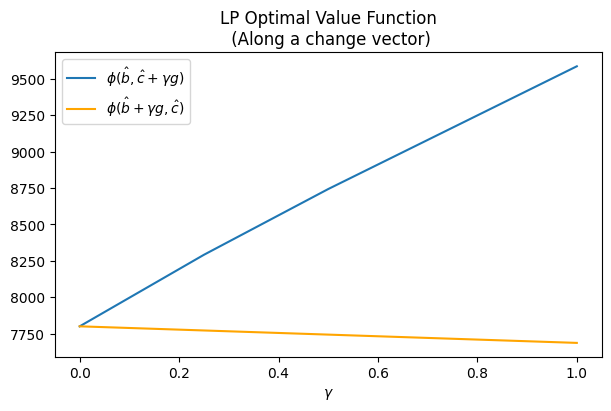

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), layout='constrained')
plt.plot(gamma, z_c, color='#1f77b4', label=r'$\phi(\hat{b}, \hat{c} + \gamma g)$')
plt.plot(gamma, z_b, color='orange', label=r'$\phi(\hat{b} + \gamma g, \hat{c})$')
plt.xlabel(r'$\gamma$')
# plt.ylabel(r'$z (\gamma)$')
plt.title("LP Optimal Value Function\n (Along a change vector)")
plt.legend()

As expected, the graph of $\phi(\hat{b}, c)$ is concave (although very slightly) and the graph of $\phi(b, \hat{c})$ is convex (in fact linear).

#### By computing the gradient of $\phi$

Sensitivity analysis becomes more involved when $b$ and $c$ are varied simultaneously. Fortunately, we know that the optimal value function $\phi(b, c)$ is piecewise quadratic and continuous over the admissible set $K = K_b \times K_c$ where $K_b$ and $K_c$ are the admissible sets for $b$ and $c$ respectively [[3]](#References). Therefore, we can conclude that $\phi$ is differentiable almost everywhere on $K$ (except for some zero measure degenerate set comprising the boundaries for various critical regions). We will compute the derivative of $\phi$ at various point values $(\hat{b}, \hat{c})$ to get a sense of how the optimal value will change in response to a given change in the parameters at a fixed optimal solution $x^*$. In particular, we are interested in parameters with greatest magnitude in the gradient vector $\nabla \phi$. These are the most **sensitive parameters**, and care must be taken to ensure their accuracy.

Of course, as mentioned in the previous section, the optimal solution $x^*$ may itself change as a result of perturbations in $(b, c)$. There are methods to summarize the region in parameter space (a.k.a. critical set) for which a given $x^*$ remains optimal (for details see [[3]](#References)). However, for the sake of simplicity we will not delve into such methods here.

In [30]:
c_star = LP.value
delta = 1.0e-2
for param in LP.parameters():
    param.value += delta
    LP.solve(requires_grad=True)
    LP.derivative()
    print(
        'param: {}, delta: {}, obj_change: {}'.format(
        param.name(), delta, LP.value - c_star))
    param.value -= delta

param: cA, delta: 0.01, obj_change: 119.12411349871218
param: cB, delta: 0.01, obj_change: 115.22930286925293
param: cC, delta: 0.01, obj_change: 114.03071247698517
param: p_min_A, delta: 0.01, obj_change: 113.93026630405166
param: p_max_A, delta: 0.01, obj_change: 113.7602181066959
param: p_min_B, delta: 0.01, obj_change: 113.98395543657352
param: p_max_B, delta: 0.01, obj_change: 113.7358955176287
param: p_min_C, delta: 0.01, obj_change: 114.22248990678054
param: p_max_C, delta: 0.01, obj_change: 113.73610339234347
param: D1, delta: 0.01, obj_change: 113.72675241639445
param: D2, delta: 0.01, obj_change: 113.83022508141312
param: D3, delta: 0.01, obj_change: 113.72807242673207


As seen above, the three most sensitive parameters are `cA`, `cB` and `p_min_C` in that order. Care must be taken to ensure that these parameters are estimated / specified accurately. A negative error in these parameters will lead to an underestimation of the total cost and vice-versa. On the other hand, none of the demand parameters seem to be sensitive. So, our model is relatively insensitive to imprecise specification of the demand.

Finally, we note that while a gradient based approach directly gives us more information about the optimal value function, it makes assumptions about small perturbations in $b$ and $c$. On the other hand, sensitivity analysis along a change direction only gives us information about the behavior of the optimal value function in that direction but it does not assume the perturbations to be small. We should choose whichever method suits our needs.

# 4. A first MIP formulation<a class="anchor" id="A_first_MIP_formulation"></a>

Next, we formulate the first version of a Mixed Integer Program for our problem. Here, we get rid of the first relaxation:
1. ~All units are running and available at all times. I.e. we don't have the choice to turn a unit ON/OFF.~
2. Startup costs are ignored.
3. Minimum up- and down-time constraints do not apply.

We now have the choice to turn one or more units ON/OFF during any of the time slots. We will use a set of binary variables to model this choice.

$$
u_{j, t} :=
\begin{cases}
   1 &\text{if unit $j$ is ON in slot $t$}\\
   0 &\text{otherwise }
\end{cases}
$$

Our objective as well as the demand constraint remain unchanged. However, the output range constraint needs to be modified in order to incorporate the new $u_{j, t}$ variables.

$$
P_{j, min} u_{j, t} \le p_{j, t} \le P_{j, max} u_{j, t}\ \text{(Output Range)}\\
$$

Note that in the above formulation, if the unit $j$ is OFF in period $t$, the power output $p_{j, t}$ is forced to be zero, so that we don't have any power output contribution from an OFF unit. Below is the new MIP model



$$
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t}\\ \tag{MIP-1}
     \text{s.t.}\quad P_{j, min} u_{j, t} \le p_{j, t} \le P_{j, max} u_{j, t}\\ 
     \sum_{j \in J} p_{j, t} \ge D_t\\
     u_{j, t} \in \{0, 1\} \ \forall\ j, t
$$

Let's solve (MIP-1) with `cxvpy`

In [31]:
# ON/OFF variables
uA1 = cp.Variable(1, boolean=True, name='uA1')
uA2 = cp.Variable(1, boolean=True, name='uA2')
uA3 = cp.Variable(1, boolean=True, name='uA3')

uB1 = cp.Variable(1, boolean=True, name='uB1')
uB2 = cp.Variable(1, boolean=True, name='uB2')
uB3 = cp.Variable(1, boolean=True, name='uB3')

uC1 = cp.Variable(1, boolean=True, name='uC1')
uC2 = cp.Variable(1, boolean=True, name='uC2')
uC3 = cp.Variable(1, boolean=True, name='uC3')

In [32]:
# Objective remains unchanged
obj_MIP1 = LP.objective

In [33]:
# New constraints
MIP1_output_range_cons = [
    # output range
    pA1 >= p_min_A * uA1,
    pA1 <= p_max_A * uA1,
    pA2 >= p_min_A * uA2,
    pA2 <= p_max_A * uA2,
    pA3 >= p_min_A * uA3,
    pA3 <= p_max_A * uA3,
    
    pB1 >= p_min_B * uB1,
    pB1 <= p_max_B * uB1,
    pB2 >= p_min_B * uB2,
    pB2 <= p_max_B * uB2,
    pB3 >= p_min_B * uB3,
    pB3 <= p_max_B * uB3,
    
    pC1 >= p_min_C * uC1,
    pC1 <= p_max_C * uC1,
    pC2 >= p_min_C * uC2,
    pC2 <= p_max_C * uC2,
    pC3 >= p_min_C * uC3,
    pC3 <= p_max_C * uC3,
]

cons_MIP1 = MIP1_output_range_cons + LP_demand_cons # demand constraints don't change

In [34]:
MIP1 = cp.Problem(obj_MIP1, cons_MIP1)
MIP1.solve();
summary_MIP1 = get_result_summary(MIP1)

print(summary_MIP1['status'])
print(summary_MIP1['optimal_value'])

optimal
6600.0


In [35]:
prettify(summary_MIP1['optimal_solution'])

,variable,value
0,pA1,150.0
1,pA2,250.0
2,pA3,200.0
3,pB1,0.0
4,pB2,50.0
5,pB3,-0.0
6,pC1,0.0
7,pC2,-0.0
8,pC3,-0.0
9,uA1,1.0


The optimal cost with the basic MIP model turns out to be <mark>$6600</mark>. Note that this is <mark>\$1200 cheaper</mark> than the result of the (LP) model. Indeed, being able to choose which units to commit during each time slot has saved us some money!

Note that the model chose to fulfill all of the demand in period 1 with unit A, which is the cheapest to run. Both unit B and unit C are more expensive to run and were kept OFF during this period. For the peak demand period, unit B was turned ON to meet the additional demand and was turned back off at the end of the peak period. Unit C, which is the most expensive to run, was never turned ON.

**Note:** We will defer the discussion of sensitivity analysis for MIPs to the end once we have developed a relatively complete MIP model for our UCP.

# 5. An MIP formulation with startup costs<a class="anchor" id="An_MIP_model_with_startup_costs"></a>

Here, we get rid of the second relaxation:
1. ~All units are running and available at all times. I.e. we don't have the choice to turn a unit ON/OFF.~
2. ~Startup costs are ignored.~
3. Minimum up- and down-time constraints do not apply.

We now consider the startup costs of the units. A unit incurs a startup cost in a time period only if it was started up in that period. We need a binary variable to indicate if a unit was turnd ON in a given period. If so, the unit will incur the startup cost in that period in addition to the marginal cost. (For simplicity, we have assumed the cool-down costs to be $0$.)

We introduce a new parameter to denote the startup costs of the units

$$
    c_j^u := \text{Startup cost of unit } j\ (\$)
$$

and a new binary variable

$$
\alpha_{j, t} :=
\begin{cases}
   1 &\text{if unit $j$ was started in period $t$}\\
   0 &\text{otherwise }
\end{cases}
$$

The new objective is given by:

\begin{align*}
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t} + \alpha_{j, t} c_j^u\\
\end{align*}

The demand constraint as well as the output range constraints remain the same as for (MIP-1). However, we need a new constraint in order to ensure that $\alpha_{j, t} = 1$ if and only if unit $j$ was started up in period $t$. This constraint can be modelled by the below function

$$\alpha_{j, t} = \lfloor \frac{u_{j, t} - u_{j, t-1} + 1}{2} \rfloor$$

The above non-linear function can be expressed in terms of linear constraints as follows:

$$\alpha_{j, t} \le \frac{u_{j, t} - u_{j, t-1} + 1}{2},\ \ \ \  \alpha_{j, t} + 1 \ge \frac{u_{j, t} - u_{j, t-1} + 1}{2} + .25\qquad \text{(Startup)}$$

Our new model can be written as:

$$
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t} + \alpha_{j, t} c_j^u\\
     \text{s.t.}\quad P_{j, min} u_{j, t} \le p_{j, t} \le P_{j, max} u_{j, t}\\ 
     \sum_{j \in J} p_{j, t} \ge D_t\\ \tag{MIP-2}
     \alpha_{j, t} \le \frac{u_{j, t} - u_{j, t-1} + 1}{2}\\
     \alpha_{j, t} + 1 \ge \frac{u_{j, t} - u_{j, t-1} + 1}{2} + .25\\
     u_{j, t} \in \{0, 1\} \ \forall\ j, t\\
     \alpha_{j, t} \in \{0, 1\} \ \forall\ j, t
$$

Lets solve (MIP-2) with `cvxpy`

In [36]:
# constants
## initial states
uA0 = 1 # ON
uB0 = 0 # OFF
uC0 = 0 # OFF

In [37]:
# parameters
## startup costs
cA_up = cp.Parameter(name="cA_up")
cB_up = cp.Parameter(name="cB_up")
cC_up = cp.Parameter(name="cC_up")

cA_up.value = 1000
cB_up.value = 600
cC_up.value = 100

In [38]:
# startup variables
alpha_A1 = cp.Variable(1, boolean=True, name='alpha_A1')
alpha_A2 = cp.Variable(1, boolean=True, name='alpha_A2')
alpha_A3 = cp.Variable(1, boolean=True, name='alpha_A3')


alpha_B1 = cp.Variable(1, boolean=True, name='alpha_B1')
alpha_B2 = cp.Variable(1, boolean=True, name='alpha_B2')
alpha_B3 = cp.Variable(1, boolean=True, name='alpha_B3')


alpha_C1 = cp.Variable(1, boolean=True, name='alpha_C1')
alpha_C2 = cp.Variable(1, boolean=True, name='alpha_C2')
alpha_C3 = cp.Variable(1, boolean=True, name='alpha_C3')

In [39]:
# objective
obj_MIP2 = cp.Minimize(
    cA * (pA1 + pA2 + pA3) + cA_up * (alpha_A1 + alpha_A2 + alpha_A3) +
    cB * (pB1 + pB2 + pB3) + cB_up * (alpha_B1 + alpha_B2 + alpha_B3) +
    cC * (pC1 + pC2 + pC3) + cC_up * (alpha_C1 + alpha_C2 + alpha_C3)
)

In [40]:
# constraints
MIP2_startup_cons =  [
    alpha_A1 <= (uA1 - uA0 + 1)/2,
    alpha_A1 >= (uA1 - uA0 + 1)/2 - .75,
    alpha_A2 <= (uA2 - uA1 + 1)/2,
    alpha_A2 >= (uA2 - uA1 + 1)/2 - .75,
    alpha_A3 <= (uA3 - uA2 + 1)/2,
    alpha_A3 >= (uA3 - uA2 + 1)/2 - .75,
    
    alpha_B1 <= (uB1 - uB0 + 1)/2,
    alpha_B1 >= (uB1 - uB0 + 1)/2 - .75,
    alpha_B2 <= (uB2 - uB1 + 1)/2,
    alpha_B2 >= (uB2 - uB1 + 1)/2 - .75,
    alpha_B3 <= (uB3 - uB2 + 1)/2,
    alpha_B3 >= (uB3 - uB2 + 1)/2 - .75,
    
    alpha_C1 <= (uC1 - uC0 + 1)/2,
    alpha_C1 >= (uC1 - uC0 + 1)/2 - .75,
    alpha_C2 <= (uC2 - uC1 + 1)/2,
    alpha_C2 >= (uC2 - uC1 + 1)/2 - .75,
    alpha_C3 <= (uC3 - uC2 + 1)/2,
    alpha_C3 >= (uC3 - uC2 + 1)/2 - .75,
]
    
cons_MIP2 = MIP1.constraints + MIP2_startup_cons

In [41]:
MIP2 = cp.Problem(obj_MIP2, cons_MIP2)
MIP2.solve();
summary_MIP2 = get_result_summary(MIP2)

print(summary_MIP2['status'])
print(summary_MIP2['optimal_value'])

optimal
7100.0


In [42]:
prettify(summary_MIP2['optimal_solution'])

,variable,value
0,alpha_A1,0.0
1,alpha_A2,0.0
2,alpha_A3,0.0
3,alpha_B1,0.0
4,alpha_B2,0.0
5,alpha_B3,0.0
6,alpha_C1,0.0
7,alpha_C2,1.0
8,alpha_C3,0.0
9,pA1,150.0


The optimal value of the total cost (setup + marginal) is <mark> $7100</mark>. This optimal value is greater than the optimal value of MIP1 (\$6600) because it includes the setup cost which we ignored in MIP1.
    
Also note that, once again, the model chose to meet all of the demand in period 1 with unit A. The reason for this is two-fold. First, unit A is the cheapest to run and incurrs the smallest marginal cost. So, it makes sense to preferentially run unit A whenever possible. Second, unit A was already in ON state at the beginning of the planning horizon and did not need to be turned ON. As a result, by keeping unit A running, we avoided the setup cost for unit A.

We should also note that during the peak demand period, the model chose to turn on unit C instead of unit B as it had done in MIP1. This is because while unit B is cheaper to run than unit C, it is more expensive to start up than unit C. Since the setup cost dominates the marginal cost, the model preferred to start up unit C.

# 6. An MIP model with up- and down-time constraints<a class="anchor" id="An_MIP_model_with_up_and_down_time_constraints"></a>

Here, we get rid of the third and final relaxation:
1. ~~All units are running and available at all times. I.e. we don't have the choice to turn a unit ON/OFF.~~
2. ~~Startup costs are ignored.~~
3. ~~Minimum up- and down-time constraints do not apply.~~

We now consider the up- and down-time constraints that apply to each unit. In order to model these constraints we need need to define two new parameters:

$$
UT_j := \text{Minimum length of time (in periods/slots) that unit j must remain ON before it can be turned OFF.}\\
DT_j := \text{Minimum length of time (in periods/slots) that unit j must remain OFF before it can be turned ON.}
$$

In [43]:
# constants
# up-times and down-times
UT_A = 3
UT_B = 2
UT_C = 1
DT_A = 3
DT_B = 1
DT_C = 1

We also need a new variable to indicate if a given unit was stopped in a given period.

$$
\beta_{j, t} :=
\begin{cases}
   1 &\text{   if unit j was stopped in period t}\\
   0 &\text{   otherwise }
\end{cases}
$$

In [44]:
# variables
beta_A1 = cp.Variable(1, boolean=True, name="beta_A1")
beta_A2 = cp.Variable(1, boolean=True, name="beta_A2")
beta_A3 = cp.Variable(1, boolean=True, name="beta_A3")

beta_B1 = cp.Variable(1, boolean=True, name="beta_B1")
beta_B2 = cp.Variable(1, boolean=True, name="beta_B2")
beta_B3 = cp.Variable(1, boolean=True, name="beta_B3")

beta_C1 = cp.Variable(1, boolean=True, name="beta_C1")
beta_C2 = cp.Variable(1, boolean=True, name="beta_C2")
beta_C3 = cp.Variable(1, boolean=True, name="beta_C3")

We need to specify the shutdown constraint

$$
\beta_{j, t} = \lfloor \frac{(-u_{j, t} + u_{j, t-1} + 1)}{2} \rfloor
$$

which can be expressed in the form of linear inequalities as follows:

$$
\beta_{j, t} \le \frac{-u_{j, t} + u_{j, t-1} + 1}{2},\ \ \ \  \beta_{j, t} + 1 \ge \frac{-u_{j, t} + u_{j, t-1} + 1}{2} + .25\qquad \text{(Shut-down)}
$$

In [45]:
MIP3_shutdown_cons = [
    beta_A1 <= (-uA1 + uA0 + 1)/2,
    beta_A1 >= (-uA1 + uA0 + 1)/2 + .25,
    beta_A2 <= (-uA2 + uA1 + 1)/2,
    beta_A2 >= (-uA2 + uA1 + 1)/2 + .25,
    beta_A3 <= (-uA3 + uA2 + 1)/2,
    beta_A3 >= (-uA3 + uA2 + 1)/2 + .25,

    beta_B1 <= (-uB1 + uB0 + 1)/2,
    beta_B1 >= (-uB1 + uB0 + 1)/2 + .25,
    beta_B2 <= (-uB2 + uB1 + 1)/2,
    beta_B2 >= (-uB2 + uB1 + 1)/2 + .25,
    beta_B3 <= (-uB3 + uB2 + 1)/2,
    beta_B3 >= (-uB3 + uB2 + 1)/2 + .25,
    
    beta_C1 <= (-uC1 + uC0 + 1)/2,
    beta_C1 >= (-uC1 + uC0 + 1)/2 + .25,
    beta_C2 <= (-uC2 + uC1 + 1)/2,
    beta_C2 >= (-uC2 + uC1 + 1)/2 + .25,
    beta_C3 <= (-uC3 + uC2 + 1)/2,
    beta_C3 >= (-uC3 + uC2 + 1)/2 + .25,
]

We also need the minimum uptime constraints:

$$
\tag{Up-time}
\sum_{i=t}^{t + UT_j - 1} u_{j, i} \ge \alpha_{j,t} UT_j \ ,\qquad \forall\ t \in \{1,\ T - UT_j + 1\}\\
\sum_{i=t}^T u_{j, i} \ge \alpha_{j, t} (T - t + 1) \ ,\qquad \forall\ t \in \{T - UT_j + 2,\ T\}
$$



In [46]:
def generate_uptime_cons(j, t):
    sum = ''
    UT_j = eval('UT_{j}'.format(j=j))
    if t <= T - UT_j + 1:
        for i in range(t, t + UT_j):
            sum += 'u{j}{i} +'.format(j=j, i=i)
        sum = sum[:-1]
        sum += ' >= alpha_{j}{t} * UT_{j}'.format(j=j, t=t)
    else:
        for k in range(t, T + 1):
            sum += 'u{j}{k} +'.format(j=j, k=k)
        sum = sum[:-1]
        sum += ' >= alpha_{j}{t} * (T - {t} + 1)'.format(j=j, t=t)
    return eval(sum)

In [47]:
MIP3_uptime_cons = []
for j in ['A', 'B', 'C']:
    for t in range(1, T + 1):
        cons = generate_uptime_cons(j, t)
        print(cons)
        MIP3_uptime_cons.append(cons)

alpha_A1 @ 3.0 <= uA1 + uA2 + uA3
alpha_A2 @ 2.0 <= uA2 + uA3
alpha_A3 @ 1.0 <= uA3
alpha_B1 @ 2.0 <= uB1 + uB2
alpha_B2 @ 2.0 <= uB2 + uB3
alpha_B3 @ 1.0 <= uB3
alpha_C1 @ 1.0 <= uC1
alpha_C2 @ 1.0 <= uC2
alpha_C3 @ 1.0 <= uC3


And the minimum downtime constraints:

$$
\tag{Down-time}
\sum_{i=t}^{t + DT_j - 1} (1 - u_{j, i}) \ge \beta_{j,t} DT_j \ ,\qquad \forall\ t \in \{1,\ T - DT_j + 1\}\\
\sum_{i=t}^T (1 - u_{j, i}) \ge \beta_{j, t} (T - t + 1) \ ,\qquad \forall\ t \in \{T - DT_j + 2,\ T\}
$$

In [48]:
def generate_downtime_cons(j, t):
    sum = ''
    DT_j = eval('DT_{j}'.format(j=j))
    if t <= T - DT_j + 1:
        for i in range(t, t + DT_j):
            sum += '(1 - u{j}{i}) +'.format(j=j, i=i)
        sum = sum[:-1]
        sum += ' >= beta_{j}{t} * DT_{j}'.format(j=j, t=t)
    else:
        for k in range(t, T + 1):
            sum += '(1 - u{j}{k}) +'.format(j=j, k=k)
        sum = sum[:-1]
        sum += ' >= beta_{j}{t} * (T - {t} + 1)'.format(j=j, t=t)
    return eval(sum)

In [49]:
MIP3_downtime_cons = []
for j in ['A', 'B', 'C']:
    for t in range(1, T + 1):
        cons = generate_downtime_cons(j, t)
        print(cons)
        MIP3_downtime_cons.append(cons)

beta_A1 @ 3.0 <= 1.0 + -uA1 + 1.0 + -uA2 + 1.0 + -uA3
beta_A2 @ 2.0 <= 1.0 + -uA2 + 1.0 + -uA3
beta_A3 @ 1.0 <= 1.0 + -uA3
beta_B1 @ 1.0 <= 1.0 + -uB1
beta_B2 @ 1.0 <= 1.0 + -uB2
beta_B3 @ 1.0 <= 1.0 + -uB3
beta_C1 @ 1.0 <= 1.0 + -uC1
beta_C2 @ 1.0 <= 1.0 + -uC2
beta_C3 @ 1.0 <= 1.0 + -uC3


Finally, we need the logical constraints [1] to ensure that $\alpha_{j,t} = 1$ only when the unit is scheduled to be switched on in slot $t$ (i.e., $u_{j, t-1} = 0$ and $u_{j, t} = 1$), and $\beta_{j, t} = 1$ only when the unit is scheduled to be switched off in slot $t$ (i.e., $u_{j, t-1} = 1$ and $u_{j, t} = 0$).

$$
u_{j, t-1} - u_{j, t} + \alpha_{j, t} - \beta_{j, t} = 0\ ,\qquad \forall\ t\in T,\ j\in J \tag{Logical}
$$

In [50]:
MIP3_logical_cons = []
for j in ['A', 'B', 'C']:
    for t in range(1, T + 1):
        cons = eval('u{j}{t_1} - u{j}{t} + alpha_{j}{t} - beta_{j}{t} == 0'.format(j=j, t_1=t-1, t=t))
        print(cons)
        MIP3_logical_cons.append(cons)

1.0 + -uA1 + alpha_A1 + -beta_A1 == 0.0
uA1 + -uA2 + alpha_A2 + -beta_A2 == 0.0
uA2 + -uA3 + alpha_A3 + -beta_A3 == 0.0
0.0 + -uB1 + alpha_B1 + -beta_B1 == 0.0
uB1 + -uB2 + alpha_B2 + -beta_B2 == 0.0
uB2 + -uB3 + alpha_B3 + -beta_B3 == 0.0
0.0 + -uC1 + alpha_C1 + -beta_C1 == 0.0
uC1 + -uC2 + alpha_C2 + -beta_C2 == 0.0
uC2 + -uC3 + alpha_C3 + -beta_C3 == 0.0


Since we are ignoring the shutdown costs of the units, our objective remains the same as that in (MIP-2). Below is our final model:

$$
    \text{minimize} \sum_{t\in T} \sum_{j \in J} c_j p_{j, t} + c_j^u \alpha_{j, t} 
$$

$$
     \text{s.t.}\quad P_{j, min} u_{j, t} \le p_{j, t} \le P_{j, max} u_{j, t}\quad \text{(Output Range)}
$$

$$
     \sum_{j \in J} p_{j, t} \ge D_t\quad \text{(Demand)} 
$$

$$
     \alpha_{j, t} \le \frac{u_{j, t} - u_{j, t-1} + 1}{2},\ \alpha_{j, t} + 1 \ge \frac{u_{j, t} - u_{j, t-1} + 1}{2} + .25 \quad \text{(Startup)}
$$

$$
\sum_{i=t}^{t + UT_j - 1} u_{j, i} \ge \alpha_{j,t} UT_j \ ,\ \forall\ t \in \{1,\ T - UT_j + 1\} \quad \text{(Uptime)}
$$

$$
\sum_{i=t}^T u_{j, i} \ge \alpha_{j, t} (T - t + 1) \ ,\ \ \forall\ t \in \{T - UT_j + 2,\ T\} \quad \text{(Uptime)}
$$

$$
\sum_{i=t}^{t + DT_j - 1} (1 - u_{j, i}) \ge \beta_{j,t} DT_j \ ,\ \forall\ t \in \{1,\ T - DT_j + 1\} \quad \text{(Downtime)}
$$

$$
\sum_{i=t}^T (1 - u_{j, i}) \ge \beta_{j, t} (T - t + 1) \ ,\ \forall\ t \in \{T - DT_j + 2,\ T\}\quad \text{(Downtime)}
$$
$$
u_{j, t-1} - u_{j, t} + \alpha_{j, t} - \beta_{j, t} = 0\ ,\qquad \forall\ t\in T,\ j\in J \quad \text{(Logical)}
$$

$$
     u_{j, t} \in \{0, 1\} \ \forall\ j, t\\
     \alpha_{j, t} \in \{0, 1\} \ \forall\ j, t\\
     \beta_{j, t} \in \{0, 1\} \ \forall\ j, t \tag{MIP-3}
$$

We now solve (MIP-3) with `cvxpy`

In [51]:
MIP3_obj = MIP2.objective

In [52]:
MIP3_cons = MIP2.constraints + MIP3_uptime_cons + MIP3_downtime_cons + MIP3_logical_cons
# + MIP3_shutdown_cons

In [53]:
MIP3 = cp.Problem(MIP3_obj, MIP3_cons)
MIP3.solve();
summary_MIP3 = get_result_summary(MIP3)

print(summary_MIP3['status'])
print(summary_MIP3['optimal_value'])

optimal
7100.0


In [54]:
prettify(summary_MIP3['optimal_solution'])

,variable,value
0,alpha_A1,0.0
1,alpha_A2,0.0
2,alpha_A3,0.0
3,alpha_B1,0.0
4,alpha_B2,0.0
5,alpha_B3,0.0
6,alpha_C1,0.0
7,alpha_C2,1.0
8,alpha_C3,0.0
9,beta_A1,0.0


As it turns out, the optimal cost of scheduling the three units over the given planning horizon remains unchanged at <mark>$7100</mark>. What is interesting is that we are able to satisfy multiple additional constraints at the same total cost as MIP2! This fact is due to the (simplified) structure of our specific problem. In a real-life scenario, adding constraints can lead to increased total cost. Nevertheless, discussing the above porblem gives us insight into how MIP can be used to model and solve similar, larger problems at scale.

## 7. Parametric Sensitivity Analysis for MIP<a class="andchor" id="parametric_sensitivity_analysis_MIP"> </a>

As in the case of (LP) in Section 3, we would like to perform sensitivity analysis on the parameters of (MIP-3). However, sensitivity analysis on MIPs is not as straightforward as for LPs. The main reason is that results from Duality theory do not apply directly to the MIP case because we restrict some variables to be discrete (i.e. integers).

### By computing the gradient of $\phi$
Parametric sensitivity anslysis can still be performed by computing the gradient of the optimal value function $\phi(b, c)$ at point values of $b$ and $c$ for a particular optimal solution $x^*$. More concretely, suppose $\overline{x}^*$ denotes the values of the integer variables at $x^*$. Then **fixing the integer variables at $\overline{x}^*$ for our MIP yields an LP**, and regular LP parametric analysis can be performed as discussed in Section 3.

Once again, tha assumption is that the perturbations to the parameters are small enough that the linearity of $\phi$ holds and the integer part of the optimal solution does not change. There are methods to get around these assumptions by using the convexity and concavity of $\phi$ with respect to $b$ and $c$ respectively, as we will see in the next section.

Before moving on, note that constants specifying the up-times and down-times (e.g. `UT_A`, `DT_A`) as well as those specifying the initial state (e.g. `uA0`) are all restricted to integer values. Therefore, sensitivity analysis for these parameters would not make sense. Moreover, we cannot compute the derivative of the optimal value function with respect to these parameters anyway.  As a result, we only consider parameters that can be varied continuously, viz.
- the startup costs $c^u_j$
- the marginal (running) costs $c_j$
- the output range limits $P_{j, min}, P_{j, max}$
- the demand $D_t$

### Along a change direction
Suppose we do not want to assume that the perturbations in $b$ and $c$ are small. Then, instead of directly computing the gradient of $\phi(b, c)$, we will try to find functions that bound $\phi$ from above and below as one of $b$, $c$ is varied in the direction of a given change vector while the other is held constant. We will then progressively tighten these bounds till $\phi$ is completely determined.

#### Perturbations in $c$
Consider the Mixed Integer Program

$$\text{minimize } c^Tx\\
\text{s.t. } Ax \ge b\\
x \ge 0\\
\overline{x}\in \mathbb{Z}\tag{P}
$$

where $\overline{x}$ are restricted to be integer. We want to analyze the effect of perturbations in the $c$ vector on the optimal value function $\phi(b, c)$ of (P). We fix the $b$ vector. Perturbations in $c$ can then be characterized parametrically by writing $c = \hat{c} + \gamma g$, where $g \in \mathbb{R}^n$ is a change vector and $0 \le \gamma \le 1$. Then we can write

$$\text{minimize } (\hat{c} + \gamma g)^Tx\\
\text{s.t. } Ax \ge b\\
x \ge 0\\
\overline{x}\in \mathbb{Z}\tag{$P_{\gamma}$}
$$

Next, we write the optimal value function as a function of $\gamma$

$$
z(\gamma) = \text{min }\left\{(\hat{c} + \gamma g)^T\mid Ax \ge b, x \ge 0, \overline{x}\in \mathbb{Z}\right\}\tag{1}
$$

The function $z$ captures the changes in the optimal value of ($P_{\gamma}$) as the $c$ vector is varied continuously along the direction $g$. Let $x(\gamma_1)$ denote the optimal solution of ($P_\gamma$) for $\gamma=\gamma_1$, and let $\overline{x}(\gamma_1)$ denote the integer part of the optimal solution. Since, changeing $\gamma_1$ does not change the feasible region, $\overline{x}(\gamma_1)$ will be feasible for all $0 \le \gamma_1 \le 1$. Now suppose we fix the values of the integer variables in ($P_\gamma$) at $\overline{x}(\gamma_1)$. The resulting problem is a Linear Program and can be analyzed using tools from LP sensitivity analysis.

We define the *partial optimal value function*
$$
z(\gamma, \overline{x}(\gamma_1)) = \text{min }\left\{(\hat{c} + \gamma g)^T\mid Ax \ge b, x \ge 0, \overline{x}=\overline{x}(\gamma_1)\right\}\tag{2}
$$

Here, $z(\gamma, \overline{x}(\gamma_1))$ captures the changes in the optimal value of ($P_\gamma$) as the $c$ vector is varied continuously along the direction $g$ while keeping $\overline{x}$ fixed at $\overline{x}(\gamma_1)$. Note that $z(\gamma, \overline{x}(\gamma_1))$ is a piecewise linear, concave function of $\gamma$ [[4](#References)]. we make two important observations:

$$z(\gamma) \le z(\gamma, \overline{x}(\gamma_1))\tag{3}\ ,\ \forall\ 0 \le \gamma_1 \le 1$$

$$z(\gamma) = z(\gamma, \overline{x}(\gamma_1))\tag{4}\ \text{ whenever } \gamma = \gamma_1$$

(3) and (4) follow from the monotone property of infima.

**Remark 1.** The optimal value function of the MIP is bounded above by every partial optimal value function.

**Remark 2.** Whenever $\gamma = \gamma_1$, the optimal value function and the partial optimal value function coincide.

<img src="images/z_gamma_bounds.png" width="500" length="500">

Important consequence of the above remarks are:

- We can set $\gamma_1 := \gamma$ and analyze the partial optimal value function at $\gamma$ with the assurance that the partial optimal value function $z(\gamma, \overline{x}(\gamma))$ is identical to the optimal value function of the original MIP at $\gamma$. We can repeat this for different values of $\gamma$ to get the point values of the optimal value function of the original MIP.
- Moreover, at fixed values of $\gamma_1$, we can plot the corresponding (interpolated) partial value function which provides an upper bound on the optimal value function of the original MIP.

We now perform these steps for MIP3.

In [84]:
c_params = [p for p in MIP3.parameters() if p.name() in [
    'cA',
    'cA_up',
    'cB',
    'cB_up',
    'cC',
    'cC_up']]

In [85]:
np.random.seed(6)
c_change_vector = (np.random.random(len(c_params)) - 0.5) * 1000

print('change vector for c: ', c_change_vector)

change vector for c:  [ 392.86015144 -168.0201947   321.22912306 -458.30337427 -392.34332006
   95.05206421]


In [86]:
gammas = [0.0, 0.25, 0.50, 0.75, 1.0]
gammas_1 = [0.0, 0.25, 0.50, 0.75, 1.0]

z_MIP = []
d = {}
for g1 in gammas_1:
    z = []
    # Perturb the original MIP by g1
    for i in range(len((c_params))):
        c_params[i].value += g1 * c_change_vector[i]

    # Solve perturbed MIP
    MIP3.solve(warm_start=True);
    z_MIP.append(MIP3.value)

    # Peg the integer variables at current solution
    integer_solution_cons = []
    int_vars = [v for v in MIP3.variables() if v.attributes['boolean']]
    for v in int_vars:
        integer_solution_cons.append(v==v.value)
        v.attributes['boolean'] = False

    # Generate parital LP
    LP_new = cp.Problem(MIP3.objective, MIP3.constraints + integer_solution_cons)

    # Perturb the partial LP by g
    for g in gammas:
        for i in range(len((c_params))):
            c_params[i].value += g * c_change_vector[i]
        LP_new.solve(warm_start=True);
        z.append(LP_new.value)
        
        # Reset param values
        for i in range(len((c_params))):
            c_params[i].value -= g * c_change_vector[i]

    d[g1] = z
    
    # Reset param values
    for i in range(len((c_params))):
        c_params[i].value -= g1 * c_change_vector[i]

    # Revert to integer
    for v in int_vars:
        v.attributes['boolean'] = True

In [88]:
pd.DataFrame(d, index=d.keys())

,0.00,0.25,0.50,0.75,1.00
0.00,7099.999991,47929.159250,87258.318659,126587.477956,165916.637215
0.25,61148.494221,87258.318659,126587.477956,165916.637215,205245.796376
0.50,115196.988422,126587.477956,165916.637215,205245.796376,244574.955540
0.75,169245.482550,165916.637215,205245.796376,244574.955540,283904.114700
1.00,223293.976744,205245.796376,244574.955540,283904.114700,323233.273861


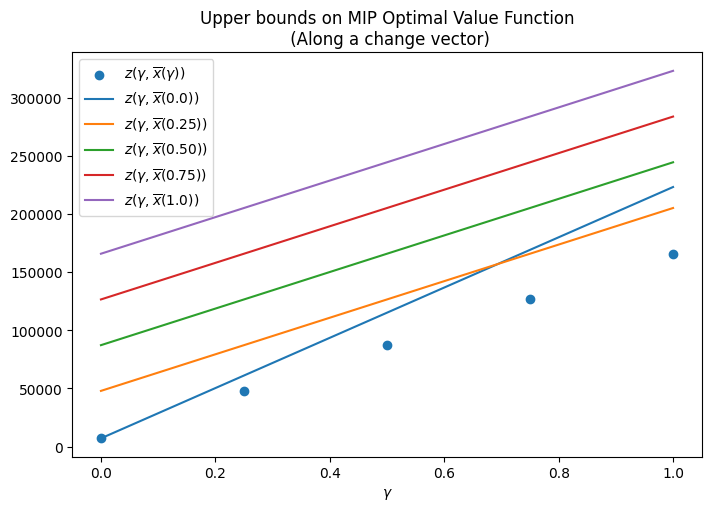

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5), layout='constrained')
plt.scatter(gammas_1, z_MIP, color='#1f77b4', label=r'$z(\gamma, \overline{x}(\gamma))$')

plt.plot(gammas, d[0.0], label='$z(\gamma, \overline{x}(0.0))$')
plt.plot(gammas, d[0.25], label='$z(\gamma, \overline{x}(0.25))$')
plt.plot(gammas, d[0.50], label='$z(\gamma, \overline{x}(0.50))$')
plt.plot(gammas, d[0.75], label='$z(\gamma, \overline{x}(0.75))$')
plt.plot(gammas, d[1.0], label='$z(\gamma, \overline{x}(1.0))$')

plt.xlabel(r'$\gamma$')
plt.title("Upper bounds on MIP Optimal Value Function\n (Along a change vector)")
plt.legend()

In the above figure, the scatter plot represent the exact point values of the optimal value function of MIP3. This is the function we are trying to fully determine. The line plots represent the partial optimal value functions corresponding to different values of $\gamma_1$. As expected, each of these plots represents an upper bound on the optimal value function. An interesting point to note is that at for $\gamma$ less than $\approx 0.7$, the best upper bound is given by $z(\gamma, \overline{x}(0.0))$ while for $\gamma$ greater than $\approx 0.7$, the best upper bound is given by $z(\gamma, \overline{x}(0.25))$.

Key points:
- In this case, we got lucky that the point values of the optimal value function indicate an almost linear plot. Hence, even a direct interpolation of the values may work. However, if the point values indicated a more complicated function, we would need a way to determine this function indirectly.
- Clearly, the current choices of $\gamma_1 \in \{0.0, 0.25, 0.50, 0.75, 1\}$ lead to upper bounds that are not very tight. How do we choose better $\gamma_1$'s? As it turns out there are more effective ways to choose $\gamma_1$ as discussed in [[4](#References)].
- Even if we choose $\gamma_1$ perfectly and determine the best upper bound function, do we know that this upper bound is actually achieved? Once again, it turns out that the best upper bound is actually achieved [[4](#References)]
- Finally, here we only considered perturbations to the $c$ vector. A similar analysis can be performed for the $b$ vector as detailed in [[4](#References)]

# 8. Conclusion<a class="anchor" id="Conclusion"></a>

In this post we analyzed a prototype example of the Unit Commitment Problem. As we saw, this problem provides furtile ground for many ideas from Linear as well as Mixed Integer Programming. In particular, we examined innovative ways of modeling constraints. We also ivestigated ways of performing sensitivity analysis for MIPs - a harder endevour than for LPs.

# 9. References<a class="anchor" id="References"></a>

[1] M. Tuffaha and J. T. Gravdahl, *Mixed-integer formulation of unit commitment problem for power systems: Focus on start-up cost,* IECON 2013 - 39th Annual Conference of the IEEE Industrial Electronics Society, Vienna, Austria, 2013, pp. 8160-8165, doi: https://doi.org/10.1109/IECON.2013.6700498.

[2] https://www.youtube.com/watch?v=jS15dU_422Q

[3] Ward, J.E., Wendell, R.E. *Approaches to sensitivity analysis in linear programming.* Ann Oper Res 27, 3–38 (1990). URL: https://doi.org/10.1007/BF02055188

[4] Larry Jenkins, (1982) *Parametric Mixed Integer Programming: An Application to Solid Waste Management.* Management Science 28(11):1270-1284. URL: https://doi.org/10.1287/mnsc.28.11.1270